# Patient Triage Prediction for Emergency Departments

Emergency Departments (EDs) require rapid and accurate triage to ensure optimal patient outcomes. Triage nurses assess patients' conditions but face challenges like inconsistent decision-making and long wait times, which can compromise care quality. An AI-driven decision support system can enhance this process by analyzing diagnoses made by nurses to predict whether a patient requires urgent attention.

*Objective*: Develop an AI-powered system that uses nurse-provided diagnoses to classify patients into urgent or non-urgent categories. This system aims to reduce triage time, improve accuracy in severity assessments, and optimize resource allocation in the ED.

## 1. Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import pickle
import warnings  # The warnings module to handle warnings during code execution
# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data = pd.read_csv("../Data/data_after_EDA2.csv")
data.head()

,index,ROWNUM,Hospital,Eligibility Class,Gender,Arrival Time,Severity Level,Deparment,Main Diagnosis,Discharge Time,Waiting Time (Minutes),Length of Stay (Minutes),Treatment Time(Minutes),Cluster,No Treatment
0,0,1,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-12-13 13:17:48,Level Ⅳ,Emergency Medicine,"Pain, unspecified",2023-12-13 16:43:00,14.0,205.0,191.0,2,0
1,1,2,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-12-08 10:59:28,Level Ⅲ,Emergency Medicine,Low back pain,2023-12-08 12:50:00,7.0,111.0,104.0,1,0
2,2,3,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-11-05 14:03:02,Level Ⅲ,Emergency Medicine,"Acute upper respiratory infection, unspecified",2023-11-05 14:54:00,24.0,51.0,27.0,1,0
3,3,4,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-10-07 22:57:41,Level Ⅲ,Emergency Medicine,Epistaxis,2023-10-08 00:09:00,26.0,71.0,0.0,1,1
4,4,5,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-10-21 21:32:17,Level Ⅳ,Emergency Medicine,"Acute upper respiratory infection, unspecified",2023-10-21 23:10:00,56.0,98.0,42.0,0,0


## 2. Data Preprocessing

In [3]:
# Load the dataset
nlp_data = pd.read_csv('../Data/updated_dataset.csv')

# Combine the data with the NLP data


features=['Eligibility Class','Gender','Arrival Time','Severity Level','Main Diagnosis']

# Drop the 'Main Diagnosis' column
data = data[features]

data = pd.concat([data, nlp_data], axis=1)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])


# Convert the 'Severity Level' column to numerical
level_mapping = {
    'Level Ⅰ': 1,
    'Level Ⅱ': 2,
    'Level Ⅲ': 3,
    'Level Ⅳ': 4,
    'Level Ⅴ': 5,
    'Unrated': 0
}

data = data[data['Severity Level'] != 'Unrated']

data['Severity Level'] = data['Severity Level'].replace(level_mapping)
data['Severity Level'] = data['Severity Level'].astype(int)

In [4]:
data.nunique()

Eligibility Class        4
Gender                   2
Arrival Time         93177
Severity Level           5
Main Diagnosis        1779
                     ...  
vaginal                  2
vomit                    2
wheeze                   2
wound                    2
wrist                    2
Length: 116, dtype: int64

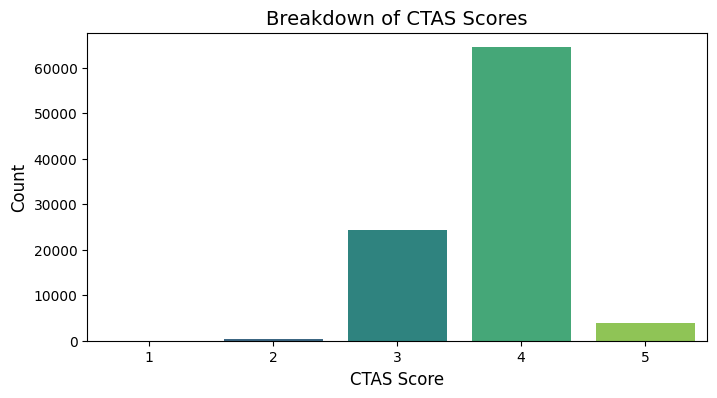

In [5]:
# Create a count plot using seaborn
plt.figure(figsize=(8, 4))
sns.countplot(x='Severity Level', data=data, palette='viridis')

# Set the labels and title
plt.xlabel('CTAS Score', size=12)
plt.ylabel('Count', size=12)
plt.title('Breakdown of CTAS Scores', size=14)
plt.show()

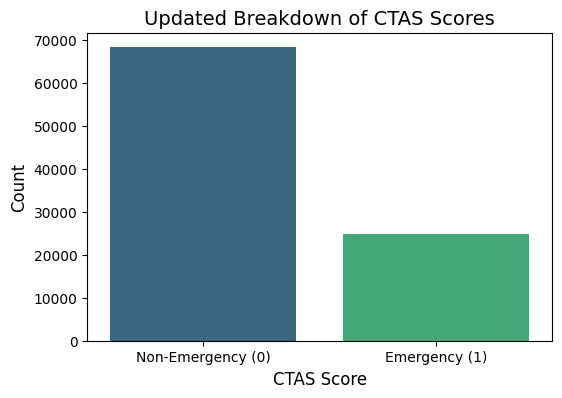

In [6]:
# Grouping the KTAS classes into emergency (1) and non-emergency (0)
data["Emergency"] = np.where(data["Severity Level"] < 4, 1, 0)

# Count the values in Emergency
CTAS_counts = data['Emergency'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=CTAS_counts.index, y=CTAS_counts.values, palette='viridis')

# Set the labels and title
plt.xlabel('CTAS Score', size=12)
plt.ylabel('Count', size=12)
plt.title('Updated Breakdown of CTAS Scores', size=14)

# Show the plot
plt.xticks(ticks=[0, 1], labels=['Non-Emergency (0)', 'Emergency (1)'])  # Customize x-ticks if necessary
plt.show()

In [7]:
# Combine the data with the NLP data
# Generate list of NLP feature and time feature columns
feature_columns = nlp_data.columns[1:].tolist()
feature_columns += [
    
    'Eligibility Class', 
    'Gender', 
]

# Convert Gender to numerical
gender_mapping = {'Female': 0, 'Male': 1}
data['Gender'] = data['Gender'].map(gender_mapping)


Eligibility_map={'ROYAL COMMISSION':0,'EXEMPT':1,'INSURANCE':2,'CASH':3}
data['Eligibility Class'] = data['Eligibility Class'].map(Eligibility_map)



X=data[feature_columns]
y=data['Emergency']



## 3. Model Training and Evaluation 

In [8]:
def model_training(X_train, X_test, y_train, y_test):

    # Initialize classifiers
    classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
    }

# Train
    results = {}
    for name, clf in classifiers.items():
    # Fit the model
        clf.fit(X_train, y_train)
    
    # Make predictions
        y_pred = clf.predict(X_test)
    
    # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        results[name] = {'accuracy': accuracy, 'report': report, 'confusion_matrix': confusion}

        log_metrics = evaluate_model(y_test, y_pred, name)
        model_results.append(log_metrics)
# Evaluate each classifier
    for name, result in results.items():
        print(f"Model: {name}")
        print("Accuracy:", result['accuracy'])
        print("Classification Report:")
        print(result['report'])
        sns.heatmap(result['confusion_matrix'], annot=True, fmt="d")
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

In [9]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate the model and return a dictionary of performance metrics."""
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics


# List to store all model results
model_results = []

### A) Original Data (Before Applying Class Balancing Techniques)

Model: Logistic Regression
Accuracy: 0.7814679686661659
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.87     13726
           1       0.69      0.31      0.42      4912

    accuracy                           0.78     18638
   macro avg       0.74      0.63      0.64     18638
weighted avg       0.77      0.78      0.75     18638



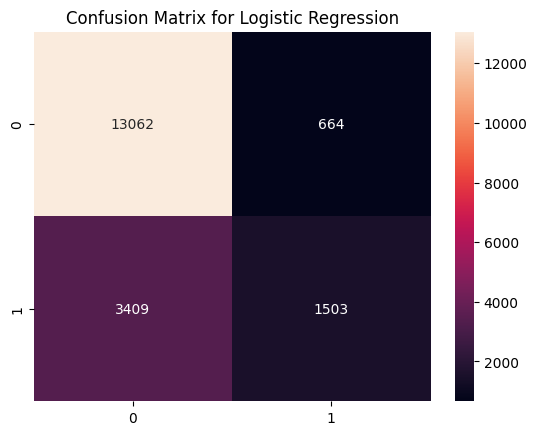

Model: Random Forest
Accuracy: 0.7802875845047752
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     13726
           1       0.67      0.33      0.44      4912

    accuracy                           0.78     18638
   macro avg       0.73      0.64      0.65     18638
weighted avg       0.76      0.78      0.75     18638



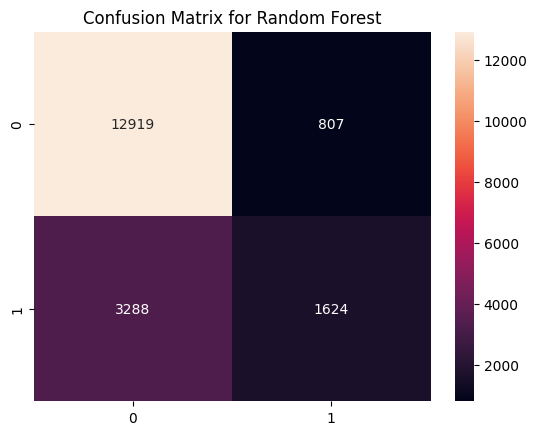

Model: SVM
Accuracy: 0.782111814572379
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     13726
           1       0.70      0.30      0.42      4912

    accuracy                           0.78     18638
   macro avg       0.75      0.63      0.64     18638
weighted avg       0.77      0.78      0.75     18638



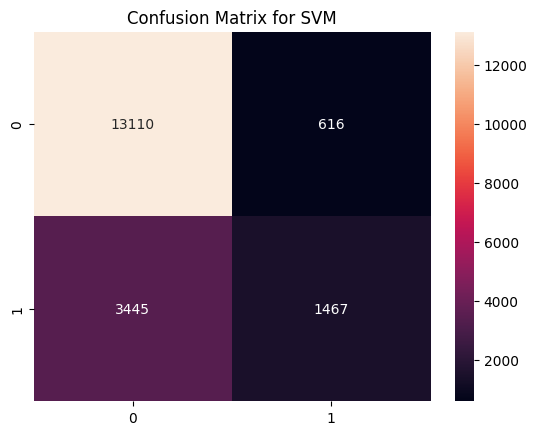

Model: KNN
Accuracy: 0.7688593196694924
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86     13726
           1       0.62      0.33      0.43      4912

    accuracy                           0.77     18638
   macro avg       0.70      0.63      0.64     18638
weighted avg       0.75      0.77      0.74     18638



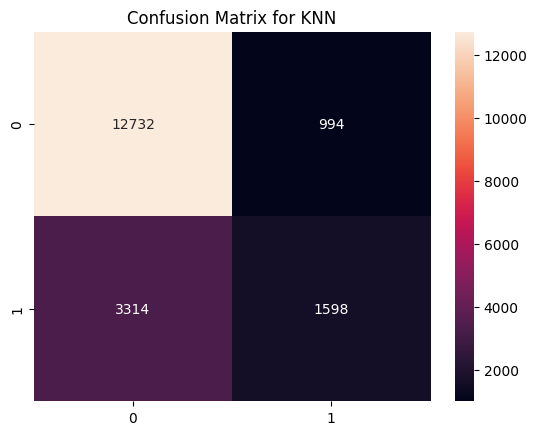

Model: Naive Bayes
Accuracy: 0.7462710591265157
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     13726
           1       0.52      0.49      0.50      4912

    accuracy                           0.75     18638
   macro avg       0.67      0.66      0.67     18638
weighted avg       0.74      0.75      0.74     18638



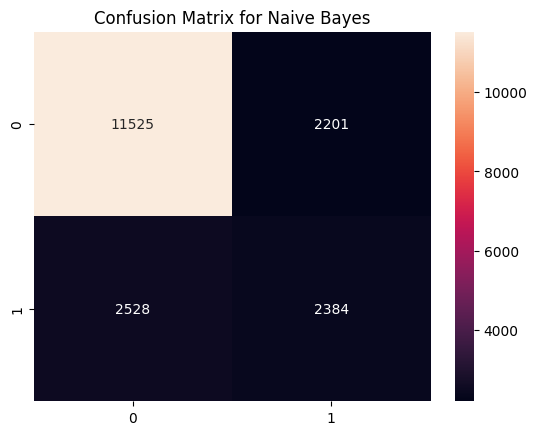

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_training(X_train, X_test, y_train, y_test)

In [11]:
# Convert list of results to DataFrame
results_df = pd.DataFrame(model_results)

# Display the DataFrame
print(results_df)



                 model  accuracy  precision    recall        f1
0  Logistic Regression  0.781468   0.766822  0.781468  0.749031
1        Random Forest  0.780288   0.763104  0.780288  0.752276
2                  SVM  0.782112   0.768810  0.782112  0.748229
3                  KNN  0.768859   0.746832  0.768859  0.742135
4          Naive Bayes  0.746271   0.741005  0.746271  0.743396


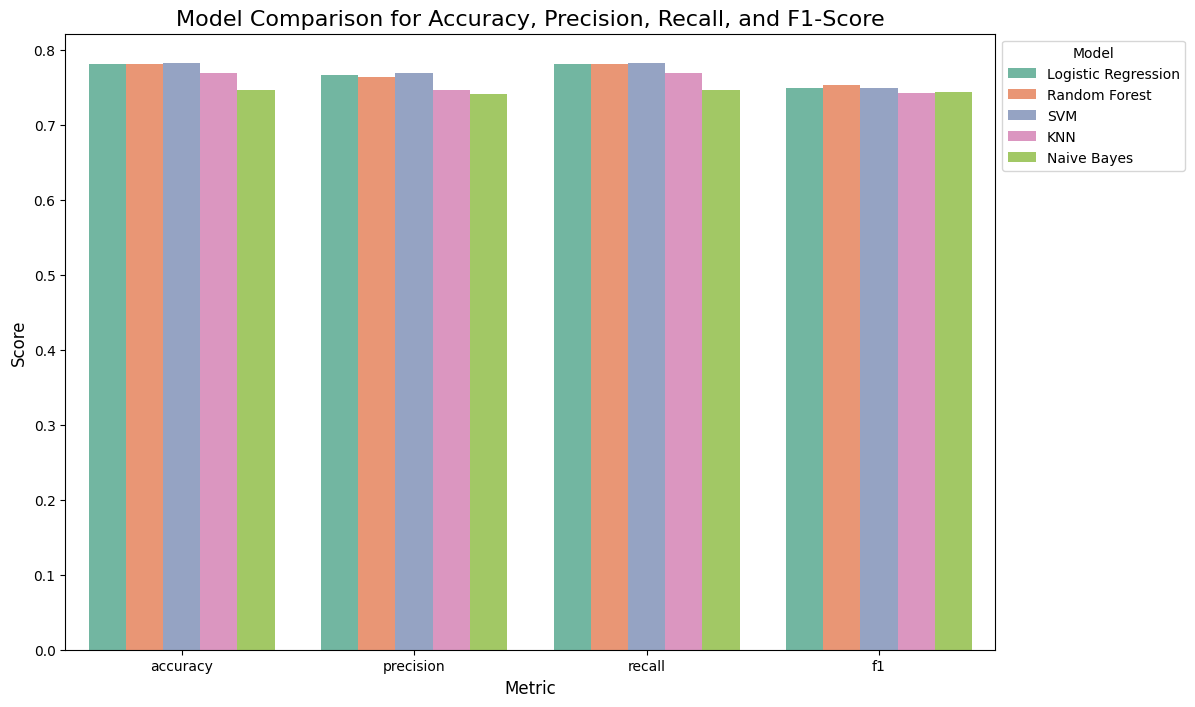

In [12]:
# Reshape the DataFrame to a long format
results_long = pd.melt(results_df, id_vars=['model'], value_vars=['accuracy', 'precision', 'recall', 'f1'],
                       var_name='metric', value_name='value')

# Create a barplot for all metrics in one figure
plt.figure(figsize=(12, 8))
sns.barplot(x='metric', y='value', hue='model', data=results_long, palette='Set2')

# Add titles and labels
plt.title('Model Comparison for Accuracy, Precision, Recall, and F1-Score', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Display the plot
plt.show()


### B) Applying Undersampling

Original class distribution:
Emergency
0    68358
1    24831
Name: count, dtype: int64

Resampled class distribution:
Emergency
0    24831
1    24831
Name: count, dtype: int64
Model: Logistic Regression
Accuracy: 0.694050135910601
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      4968
           1       0.71      0.66      0.68      4965

    accuracy                           0.69      9933
   macro avg       0.69      0.69      0.69      9933
weighted avg       0.69      0.69      0.69      9933



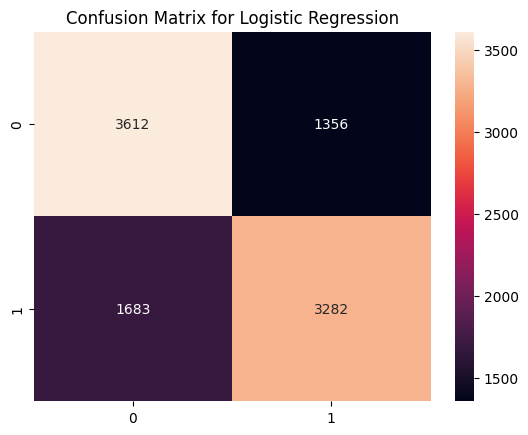

Model: Random Forest
Accuracy: 0.695761602738347
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      4968
           1       0.71      0.67      0.69      4965

    accuracy                           0.70      9933
   macro avg       0.70      0.70      0.70      9933
weighted avg       0.70      0.70      0.70      9933



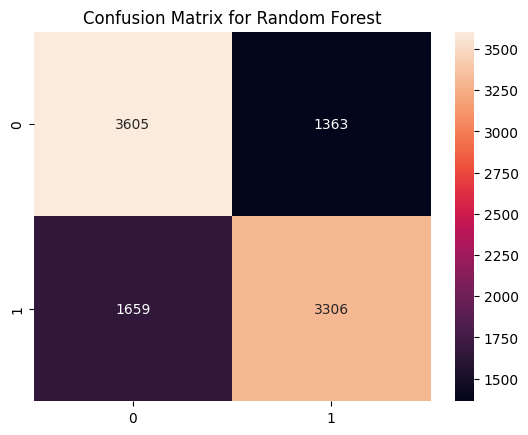

Model: SVM
Accuracy: 0.6956609282190678
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      4968
           1       0.71      0.66      0.69      4965

    accuracy                           0.70      9933
   macro avg       0.70      0.70      0.70      9933
weighted avg       0.70      0.70      0.70      9933



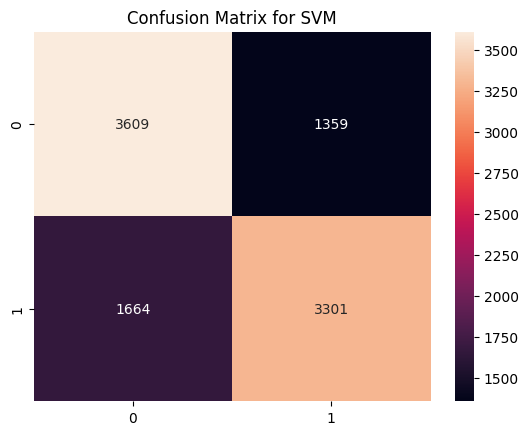

Model: KNN
Accuracy: 0.6602234974327997
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      4968
           1       0.68      0.60      0.64      4965

    accuracy                           0.66      9933
   macro avg       0.66      0.66      0.66      9933
weighted avg       0.66      0.66      0.66      9933



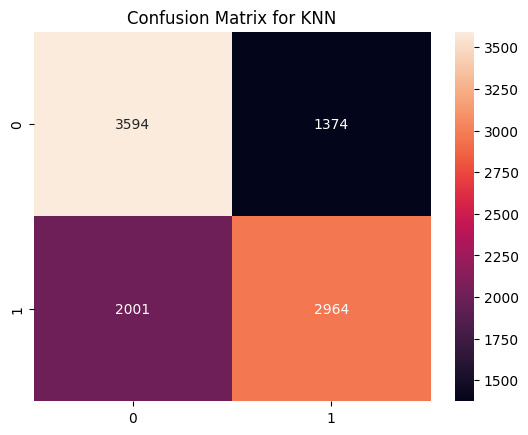

Model: Naive Bayes
Accuracy: 0.6577066344508204
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      4968
           1       0.76      0.46      0.58      4965

    accuracy                           0.66      9933
   macro avg       0.69      0.66      0.64      9933
weighted avg       0.69      0.66      0.64      9933



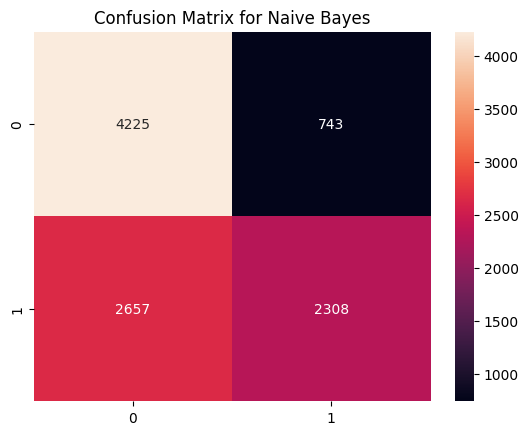

                 model  accuracy  precision    recall        f1
0  Logistic Regression  0.694050   0.694889  0.694050  0.693715
1        Random Forest  0.695762   0.696454  0.695762  0.695488
2                  SVM  0.695661   0.696396  0.695661  0.695371
3                  KNN  0.660223   0.662806  0.660223  0.658858
4          Naive Bayes  0.657707   0.685175  0.657707  0.644485


In [13]:

# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with resampled data
resampled_df = pd.DataFrame(X_resampled)
resampled_df['Emergency'] = y_resampled

# Display the original and resampled class distribution
print("Original class distribution:")
print(y.value_counts())
print("\nResampled class distribution:")
print(resampled_df['Emergency'].value_counts())


x_resample=resampled_df.drop(columns='Emergency')
y_resample=resampled_df['Emergency']

# List to store all model results
model_results = []


X_train, X_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

model_training(X_train, X_test, y_train, y_test)

# Convert list of results to DataFrame
results_df = pd.DataFrame(model_results)

# Display the DataFrame
print(results_df)

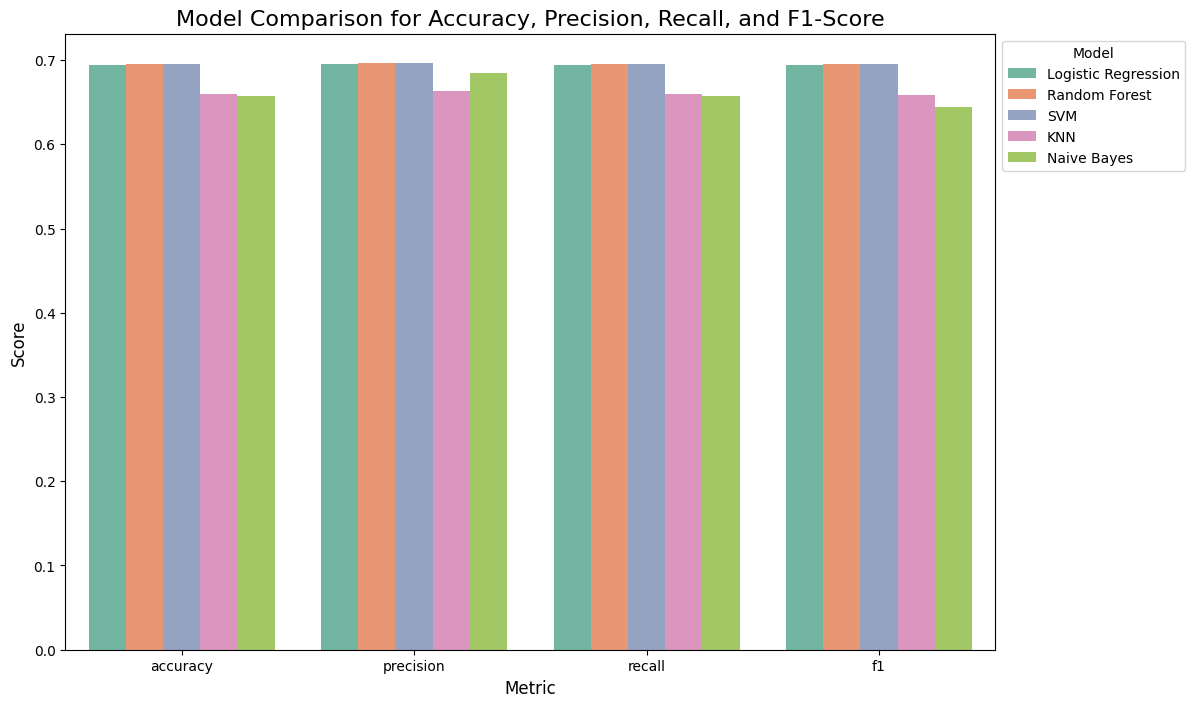

In [14]:
# Reshape the DataFrame to a long format
results_long = pd.melt(results_df, id_vars=['model'], value_vars=['accuracy', 'precision', 'recall', 'f1'],
                       var_name='metric', value_name='value')

# Create a barplot for all metrics in one figure
plt.figure(figsize=(12, 8))
sns.barplot(x='metric', y='value', hue='model', data=results_long, palette='Set2')

# Add titles and labels
plt.title('Model Comparison for Accuracy, Precision, Recall, and F1-Score', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Display the plot
plt.show()


### C) Applying Oversampling (SMOTE)

In [15]:
# The reason of that is the imbalance of the dataset, we can use SMOTE to balance the dataset


Model: Logistic Regression
Accuracy: 0.7125764567013628
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79     13726
           1       0.47      0.67      0.55      4912

    accuracy                           0.71     18638
   macro avg       0.66      0.70      0.67     18638
weighted avg       0.76      0.71      0.73     18638



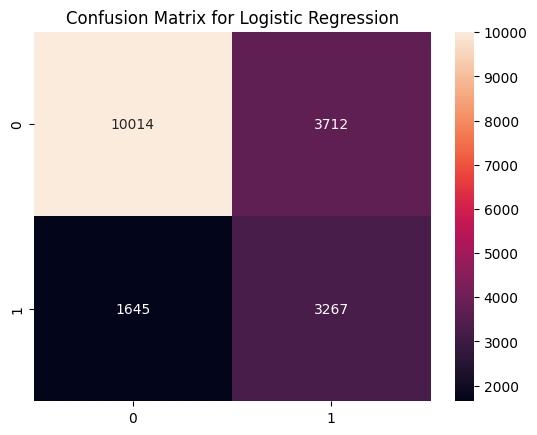

Model: Random Forest
Accuracy: 0.7160103015344994
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79     13726
           1       0.47      0.66      0.55      4912

    accuracy                           0.72     18638
   macro avg       0.66      0.70      0.67     18638
weighted avg       0.76      0.72      0.73     18638



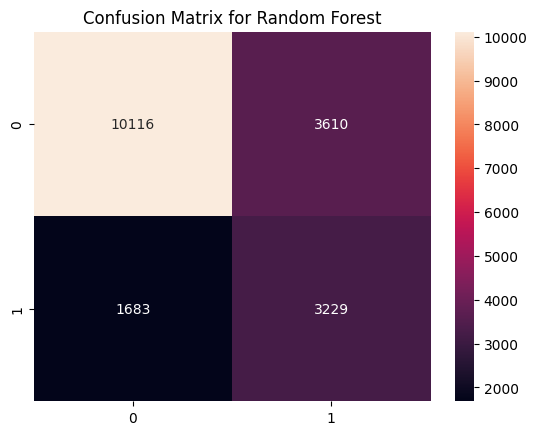

Model: SVM
Accuracy: 0.7150445326751798
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79     13726
           1       0.47      0.66      0.55      4912

    accuracy                           0.72     18638
   macro avg       0.66      0.70      0.67     18638
weighted avg       0.76      0.72      0.73     18638



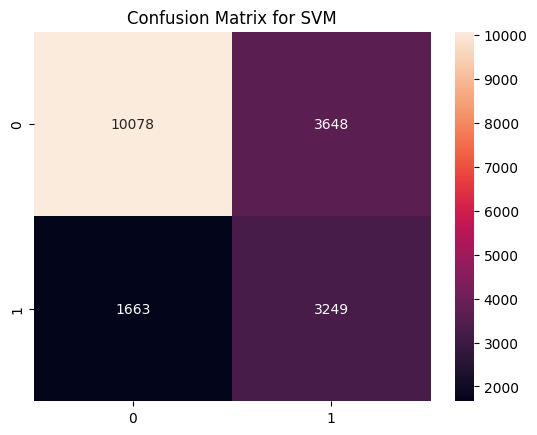

Model: KNN
Accuracy: 0.7625281682583969
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     13726
           1       0.59      0.34      0.43      4912

    accuracy                           0.76     18638
   macro avg       0.69      0.63      0.64     18638
weighted avg       0.74      0.76      0.74     18638



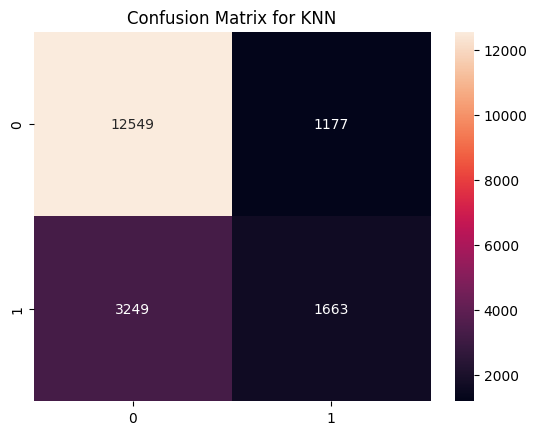

Model: Naive Bayes
Accuracy: 0.7299602961691168
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     13726
           1       0.49      0.55      0.52      4912

    accuracy                           0.73     18638
   macro avg       0.66      0.67      0.67     18638
weighted avg       0.74      0.73      0.73     18638



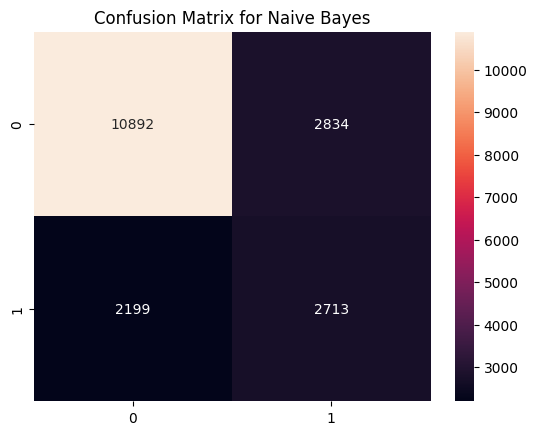

                 model  accuracy  precision    recall        f1
0  Logistic Regression  0.712576   0.755916  0.712576  0.725856
1        Random Forest  0.716010   0.755838  0.716010  0.728576
2                  SVM  0.715045   0.756292  0.715045  0.727889
3                  KNN  0.762528   0.739318  0.762528  0.739125
4          Naive Bayes  0.729960   0.741644  0.729960  0.734961


In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)


model_results = []

model_training(X_train_sm, X_test, y_train_sm, y_test)


# Convert list of results to DataFrame
results_df = pd.DataFrame(model_results)

# Display the DataFrame
print(results_df)


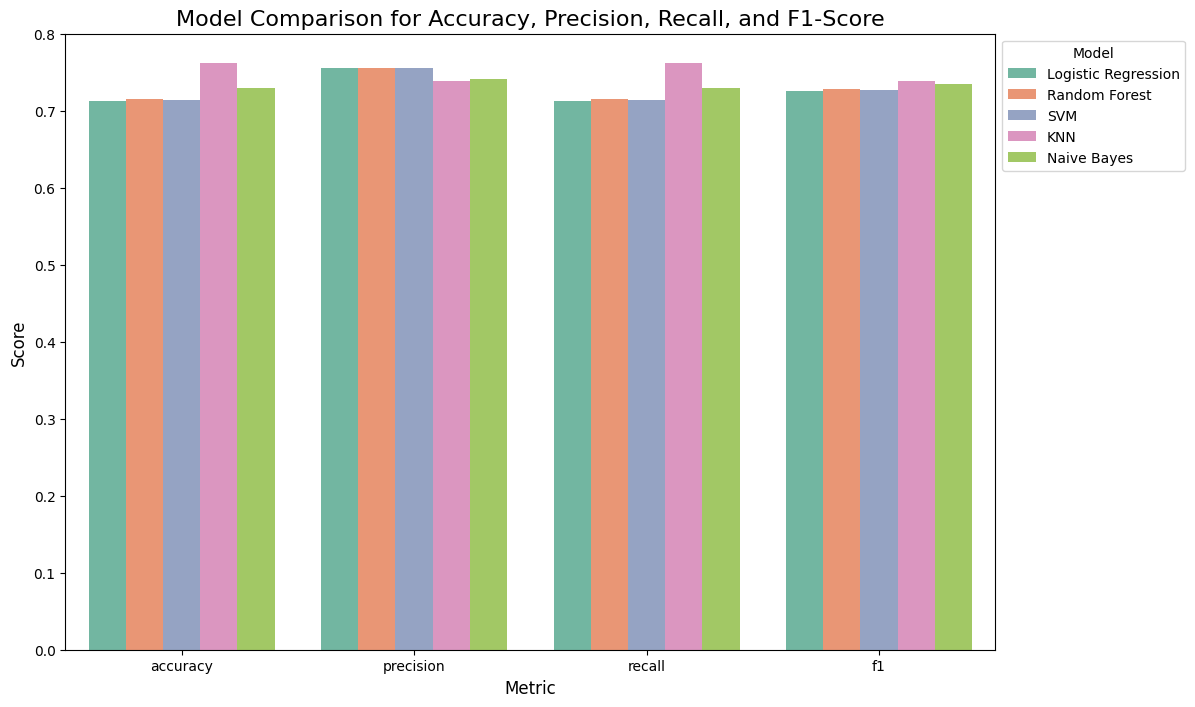

In [17]:
# Reshape the DataFrame to a long format
results_long = pd.melt(results_df, id_vars=['model'], value_vars=['accuracy', 'precision', 'recall', 'f1'],
                       var_name='metric', value_name='value')

# Create a barplot for all metrics in one figure
plt.figure(figsize=(12, 8))
sns.barplot(x='metric', y='value', hue='model', data=results_long, palette='Set2')

# Add titles and labels
plt.title('Model Comparison for Accuracy, Precision, Recall, and F1-Score', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Display the plot
plt.show()


## 4. Model Selection 

In [18]:
# Fit the model
svc=SVC()
svc.fit(X, y)

with open('../Models/CTAS_model.pkl', 'wb') as file:
    pickle.dump(svc, file)
    

## 5. Make New Prediction

In [19]:
def make_prediction(diagnosis,eligibility,gender):
    data = {
        "Main Diagnosis": [diagnosis],
        'Eligibility Class':[eligibility],
        "Gender":[gender],
    }


    # Create DataFrame from input data
    df_new = pd.DataFrame(data, index=[0])
    with open('../Models/nlp_diagnosis.pkl', 'rb') as file:
        vectorizer = pickle.load(file)

    
    df_new_encoded = vectorizer.transform(df_new['Main Diagnosis'])
    df_new_features = pd.DataFrame(df_new_encoded.toarray(), columns=vectorizer.get_feature_names_out())
    #print(df_new_features)

    df_new["Eligibility Class"]=df_new["Eligibility Class"].replace({'ROYAL COMMISSION':0,'EXEMPT':1,'INSURANCE':2,'CASH':3})
    df_new["Gender"]=df_new["Gender"].replace({'Female': 0, 'Male': 1})
    
    # Combine all features into one DataFrame
    df_new=df_new.drop(columns=['Main Diagnosis'])
    #print(df_new.info())
    df_final = pd.concat([df_new_features, df_new], axis=1)

    
    with open('../Models/CTAS_model.pkl', 'rb') as file:
        ctas_model = pickle.load(file)
    
    # Predict using the Random Forest model
    prediction = ctas_model.predict(df_final)
    
    # Return the prediction result

    return prediction
    


In [20]:
make_prediction('chest pain', 'CASH','Male')

array([1])

In [21]:
make_prediction('upper respiratory infection', 'ROYAL COMMISSION','Female')

array([0])